In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch 
import os
import glob
from matplotlib import pyplot as plt
import os
import torch
# Cd to code
import os
import sys
os.chdir('/cluster/home/kheuto01/code/prob_diff_topk')
sys.path.append('/cluster/home/kheuto01/code/prob_diff_topk')

from datasets import example_datasets, to_numpy
from torch_models import  MixtureOfTruncNormModel, torch_bpr_uncurried, deterministic_bpr
from torch_perturb.torch_pert_topk import PerturbedTopK
from distributions import QuantizedNormal



2024-08-26 14:43:06.861898: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-26 14:43:06.899276: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-26 14:43:06.899318: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-26 14:43:06.900210: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-26 14:43:06.906132: I tensorflow/core/platform/cpu_feature_guar

In [3]:
seed=360
# tracts/distributions
S=12

# total timepoints
T= 500
K=3

low_3 = [QuantizedNormal(10, 0.3) for _ in range(3)]
lowmid_3 = [QuantizedNormal(35, 0.3) for _ in range(3)]
highmid_3 = [QuantizedNormal(45, 0.3) for _ in range(3)]
high_3 = [QuantizedNormal(50,0.3) for _ in range(3)]

dist_S = low_3 + lowmid_3 + highmid_3 + high_3 
train_y_TS = np.zeros((T, S))
for s, dist in enumerate(dist_S):
    random_state = np.random.RandomState(10000 * seed + s*123456)
    train_y_TS[:, s] = dist.rvs(size=T, random_state=random_state)

(array([0.14077381, 0.00803571, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00644841,
        0.13482143, 0.00753968, 0.        , 0.        , 0.        ,
        0.00555556, 0.13740079, 0.00585317, 0.00704365, 0.14176587]),
 array([ 9.  , 10.68, 12.36, 14.04, 15.72, 17.4 , 19.08, 20.76, 22.44,
        24.12, 25.8 , 27.48, 29.16, 30.84, 32.52, 34.2 , 35.88, 37.56,
        39.24, 40.92, 42.6 , 44.28, 45.96, 47.64, 49.32, 51.  ]),
 <BarContainer object of 25 artists>)

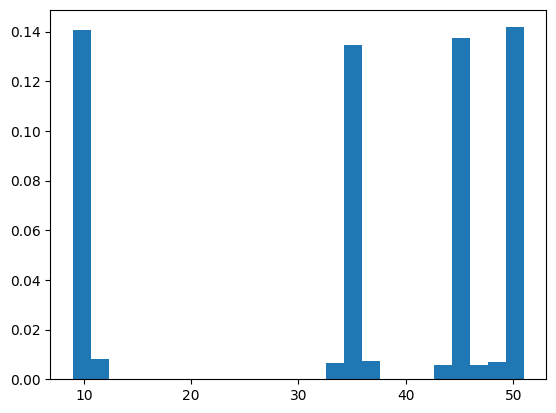

In [5]:
plt.hist(train_y_TS[:, :].flatten(), bins=25, density=True)